In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten,Conv2D,BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.layers import MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


2021-11-26 16:50:12.041594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sagar/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-26 16:50:12.041956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dir_train="data-set/train"
dir_test="data-set/test"

In [3]:
# Normalization: Scaling data to the range of 0-1 is traditionally referred to as normalization.
train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)


# Making train data from the set of images.
train_data = train_data_gen.flow_from_directory(
    directory=dir_train,
    target_size= (48,48), #Change later to find the values.
    batch_size=48,
    color_mode='grayscale',
    class_mode='categorical'
)
# Making test data from the set of images.
test_data = train_data_gen.flow_from_directory(
    directory=dir_test,
    target_size= (48,48), #Change later to find the values.
    batch_size=48,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


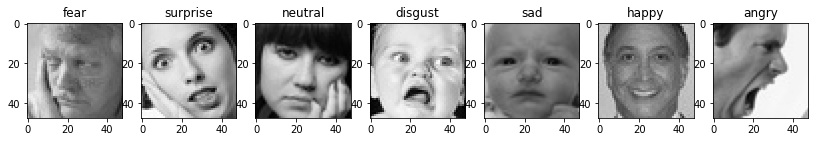

In [4]:
plt.figure(figsize=(14,22))
counter = 1
for expression in os.listdir(dir_train):
    img = load_img((dir_train+"/" + expression +'/'+ os.listdir(dir_train +"/"+ expression)[1]))
    plt.subplot(1,7,counter)
    plt.imshow(img)
    plt.title(expression)
    counter += 1
plt.show()

In [5]:
model = Sequential([

        # input layer
        Conv2D(filters=32,
               kernel_size=(3,3),
               padding='same',
               activation = 'relu',
               input_shape=(48,48,1)),
        Conv2D(filters=64,
               kernel_size=(3,3),
               padding='same', 
               activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        #hidden layers
        # 1st layers
        Conv2D(filters=128,
               kernel_size=(3,3), 
               padding='same', 
               activation='relu',
               kernel_regularizer=l2(0.01)),
    
        # 2nd layer
        Conv2D(filters=256, 
               kernel_size=(3,3), 
               padding='same', 
               activation='relu',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
     # 3rd layer
        Conv2D(filters=512, 
               kernel_size=(3,3), 
               padding='same', 
               activation='relu',
               kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        # Flattenning the layer and passing making NN
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
    
    
        # output layer
        Dense(7, activation='softmax')
    ])
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001,decay=1e-6),metrics=['accuracy'])

2021-11-26 16:50:16.118693: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-26 16:50:16.118770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SagarP): /proc/driver/nvidia/version does not exist
2021-11-26 16:50:16.119667: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-26 16:50:16.219824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2021-11-26 16:50:16.228251: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% of free system memory.
2021-11-26 16:50:16

### Model Summary

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

### Model Diagram
ref:: https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/

In [7]:
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### CallBacks

In [8]:
filepath = "emotion-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode="min")

earlystop = EarlyStopping(monitor='val_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [ ]:
emotion_model_info = model.fit(
        train_data,
        steps_per_epoch=train_data.samples // 64,
        epochs=100,
        validation_data=test_data,
        validation_steps=test_data.samples // 64,
        callbacks=callbacks)
model.save_weights("emotion_model.h5")

In [10]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
model.load_weights("kaggle output/fiinal_output/emotion_model (2).h5")
 

In [ ]:
model.save_weights('model.h5')
print(emotion_model_info.history.keys())
plt.plot(range(94),emotion_model_info.history["accuracy"],label="train")
plt.plot(range(94),emotion_model_info.history["val_accuracy"],label="validation")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Valid Accuracy over the epochs",size=15)
plt.savefig('acc_val_acc.png', transparent=True)

In [ ]:
print(emotion_model_info.history.keys())
plt.plot(range(94),emotion_model_info.history["val_loss"],label="validation")
plt.plot(range(94),emotion_model_info.history["loss"],label="train")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Valid Loss over the epochs",size=15)
plt.savefig('val_loss_vs_loss.png', transparent=True)




In [ ]:
train_loss, train_accu = model.evaluate(train_data)
test_loss, test_accu = model.evaluate(test_data)
print("Final training accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))
print("Final test loss = {:.2f} , validation loss = {:.2f}".format(train_loss, test_loss))


In [14]:
# define a video capture object
vid = cv2.VideoCapture(-2)
while(True):

    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    if not ret:
        break

    face_region = cv2.CascadeClassifier(
        cv2.data.haarcascades+
        "haarcascade_frontalface_default.xml"
    ) 
    # converting to grayscale, as IT take value in opposite direction BGR, using grayscale
    # make it easy to compute as it only has one channel only.
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_region.detectMultiScale(
        gray, scaleFactor=1.3, minNeighbors=5)

    if faces == ():
        print("No faces found")

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (127, 0, 255), 2)
        roi_gray = gray[y:y+h, x:x+w]
        cropped_img = np.expand_dims(np.expand_dims(
            cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        max_index = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[max_index], (x+15, y+20),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (127, 0, 255), 2, cv2.LINE_4)
    # Display the resulting frameq
    cv2.imshow("frame", cv2.resize(frame, (1200,860),interpolation = cv2.INTER_CUBIC))
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()




/tmp/ipykernel_35076/848093293.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():


In [12]:
cv2.ocl.setUseOpenCL(False)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    bounding_box = cv2.CascadeClassifier(cv2.data.haarcascades+
        "haarcascade_frontalface_default.xml")
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=10)
    for (x, y, w, h) in num_faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        emotion_prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(emotion_prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow('Video', cv2.resize(frame,(1200,860),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

### Testing happy face

In [ ]:
img = image.load_img("data-set/test/happy/PrivateTest_95094.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
img_index = result.index(max(result))
print(emotion_dict[img_index])
plt.show()


### Testing images

In [ ]:
for expression in os.listdir(dir_train):
    img = image.load_img((dir_train+"/" + expression +'/'+ os.listdir(dir_train +"/"+ expression)[1]),target_size = (48,48),color_mode = "grayscale")
    img = np.array(img)
    plt.imshow(img)
    print(img.shape)

    img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
    img = img.reshape(1,48,48,1)
    result = model.predict(img)
    result = list(result[0])
    img_index = result.index(max(result))
    print(emotion_dict[img_index])
    plt.show()

2021-11-22 22:55:01.668644: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28311552 exceeds 10% of free system memory.


Confusion Matrix
[[136  18 104 248 198 145 109]
 [ 19   1   7  27  23  15  19]
 [134  16 115 263 189 177 130]
 [283  21 207 446 334 273 210]
 [180  17 132 296 245 204 159]
 [161  12 137 319 248 212 158]
 [103  12  86 220 166 133 111]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       958
     disgust       0.01      0.01      0.01       111
        fear       0.15      0.11      0.13      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.20      0.19      1233
         sad       0.18      0.17      0.18      1247
    surprise       0.12      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178



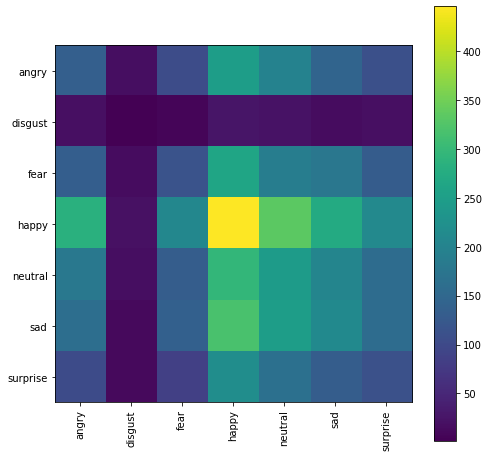

In [ ]:
y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_data.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_data.classes, y_pred)

print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_data.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:

ax = sns.heatmap(cm_test/cm_test.sum(axis=1)[:, np.newaxis], annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Face Emotion Detection Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Emotion Category')
ax.set_ylabel('Actual Emotion Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(emotion_dict.values()))
ax.yaxis.set_ticklabels(list(emotion_dict.values()))

## Display the visualization of the Confusion Matrix.
plt.show()